In [61]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from cvnn import layers 

In [62]:
data_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'
file_loc = '/home/saumya/Documents/NRSC internship/Dataset/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'

In [63]:
# file_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/scene_HH/'
# data_loc = '/home/saumya/Documents/NRSC SAR CVNN/Data-sets/MRSDP_SLC_DATA/EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [64]:
# file_loc = 'EOS4_FRS1_SLC/scene_HH/'
# data_loc = 'EOS4_FRS1_SLC/Pauli_Lee5X5/'

In [65]:
mask = np.load(data_loc+'mask_sk.npy')
mask[mask == 3] = 1

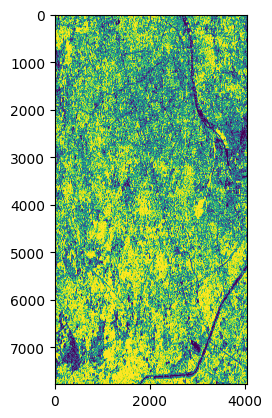

In [66]:
plt.imshow(mask)

In [67]:
inputs = np.load(file_loc +'input.npy')

In [68]:
import patchify as pat

In [69]:
img_dim  = 128

In [70]:
patches_inp = pat.patchify(inputs, (img_dim, img_dim), step=img_dim)
patches_mask = pat.patchify(mask, (img_dim,img_dim), step=img_dim)

In [71]:
patches_mask.shape[0]*patches_mask.shape[1]

1860

In [72]:
patches_inp.shape

(60, 31, 128, 128)

In [73]:
input_img = np.reshape(patches_inp, [patches_mask.shape[0]*patches_mask.shape[1], img_dim, img_dim])
mask_img = np.reshape(patches_mask, [patches_mask.shape[0]*patches_mask.shape[1], img_dim, img_dim])

In [74]:
input_img = np.expand_dims(input_img, -1)
mask_img = np.expand_dims(mask_img, -1)

In [75]:
input_img.dtype

dtype('complex64')

In [76]:
from keras.utils import to_categorical
classes = np.unique(mask_img[0]).astype(int)
mask_cat = to_categorical(mask_img)
mask_cat = mask_cat.astype(np.int8)

In [77]:
norm = np.abs(input_img.max())
input_img_norm = (input_img/norm).astype(np.complex64)

In [78]:
mask_cat.shape

(1860, 128, 128, 2)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_img_norm, mask_cat, test_size = 0.15, random_state = 42, shuffle=True)

In [80]:
mask_cat[0].shape

(128, 128, 2)

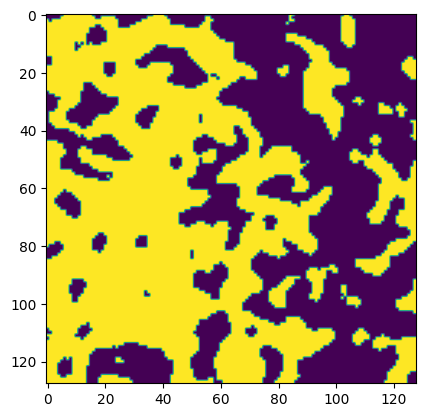

In [81]:
plt.imshow(mask_img[25])

In [82]:
X_train.shape[1:]

(128, 128, 1)

In [83]:
input_shape = (X_train.shape[1:])
# input_shape = np.array(input_shape).reshape(-1, 256, 256, 1)
dtype  = tf.complex64

In [84]:
from keras.layers import Activation
from cvnn.activations import cart_softmax, cart_relu, cart_leaky_relu

In [85]:
d_rate = 0.5

In [86]:
def _downsample_cvnn(inputs, units, dtype=dtype):
    c0 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype = dtype)(inputs)
    # c0 = layers.ComplexDropout(rate = d_rate, dtype=dtype)(c0)
    # c0 = layers.ComplexBatchNormalization(dtype=dtype)(c0)  
    # c0 = Activation(cart_leaky_relu)(c0)
    # c0 = layers.ComplexBatchNormalization(dtype=dtype)(c0)
    c1 = layers.ComplexConv2D(units, kernel_size=3, activation='cart_relu', kernel_initializer='ComplexHeNormal', padding='same', dtype= dtype)(c0)
    # c1 = layers.ComplexDropout(rate = d_rate, dtype=dtype)(c1)
    # c1 = layers.ComplexBatchNormalization(dtype=dtype)(c1)  
    # c1 = Activation(cart_relu)(c1)
    p1 = layers.ComplexMaxPooling2D((2,2), dtype=dtype)(c1)
    # p1 = layers.ComplexDropout(rate=0.3, dtype=dtype)(p1)
    return (c0, c1, p1) 

In [87]:
# def _downsample_cvnn(inputs, units):
#     c0 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(inputs)
#     c1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_size=3)(c0)
#     c2 = layers.ComplexMaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(c1)
#     return c0, c1, c2

In [88]:
def _upsample_cvnn(in1, in2, units, dtype = dtype):
    # print(in1.shape)
    t01 = layers.ComplexConv2DTranspose(units, (2, 2), strides=(2,2), activation='cart_relu', dtype=dtype, padding='same')(in1)
    # t01 = layers.ComplexDropout(0.2)(t01)
    # t01 = layers.ComplexBatchNormalization(dtype=dtype)(t01)
    # t01 = Activation(cart_leaky_relu)(t01)
    
    # crop01 = tf.keras.layers.Cropping2D(cropping=(crop, crop))(in2)
    # t01 = layers.ComplexUpSampling2D(size=4, interpolation='bilinear', data_format='channels_first')(t01)
    # print(t01.shape)
    concat01 = tf.keras.layers.concatenate([t01, in2], axis=-1)
    # concat01 = layers.ComplexBatchNormalization(dtype=dtype)(concat01)  
    # concat01 = Activation(cart_leaky_relu)(concat01)
    out1 = layers.ComplexConv2D(units, activation='cart_relu', kernel_initializer='ComplexHeNormal',kernel_size=3, dtype=dtype, padding='same')(concat01)
    # out1 = layers.ComplexDropout(rate=d_rate, dtype=dtype)(out1)
    # out1 = layers.ComplexBatchNormalization(dtype=dtype)(out1)  
    # out1 = Activation(cart_leaky_relu)(out1)

    out2 = layers.ComplexConv2D(units, activation='cart_relu', kernel_initializer='ComplexHeNormal',kernel_size=3, dtype=dtype, padding ='same')(out1)
    # out2 = layers.ComplexDropout(rate = d_rate, dtype=dtype)(out2)
    # out2 = layers.ComplexBatchNormalization(dtype=dtype)(out2)  
    # out2 = Activation(cart_relu)(out2)    
    
    return out1, out2

In [89]:
input_shape

(128, 128, 1)

In [90]:
from cvnn import losses
from keras.optimizers import Adam

In [91]:
# losses.ComplexWeightedAverageCrossEntropyIgnoreUnlabeled

In [92]:
from cvnn.metrics import ComplexCategoricalAccuracy, ComplexAverageAccuracy, ComplexPrecision, ComplexRecall

In [93]:
def cvnn_unet(dtype = tf.complex64):
    # tf.random.set_seed(1)
    inputs = layers.complex_input(shape=input_shape, dtype=dtype)

    c0, c1, c2 = _downsample_cvnn(inputs,32)
    c3, c4, c5 = _downsample_cvnn(c2, 64)
    c6, c7, c8 = _downsample_cvnn(c5, 128)
    c9, c10, c11 = _downsample_cvnn(c8, 256)
    # c61, c62, c63 = _downsample_cvnn(c11, 512) 

    
    c12 = layers.ComplexConv2D(256, activation='cart_relu', kernel_size=3, padding='same')(c11)
    # c12 = layers.ComplexDropout(rate=d_rate, dtype=dtype)(c12)
    c13 = layers.ComplexConv2D(512, activation='cart_relu', kernel_size=3, padding='same')(c12)
    # c13 = layers.ComplexDropout(rate=d_rate,dtype=dtype)(c13)


    # c64, c65 = _upsample_cvnn(c13, c62, 512, dtype)
    c14, c15 = _upsample_cvnn(c13, c10, 256, dtype)
    c16, c17 = _upsample_cvnn(c15, c7, 128, dtype)
    c18, c19 = _upsample_cvnn(c17, c4, 64, dtype)
    c20, c21 = _upsample_cvnn(c19, c1, 32, dtype)

    outputs = layers.ComplexConv2D(2, kernel_size=1, activation = 'softmax_real_with_avg', dtype=dtype)(c21)
    # outputs = layers.ComplexConv2D(1, kernel_size=1)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-net-cvnn")
    model.compile(loss=losses.ComplexAverageCrossEntropy(), optimizer=Adam(learning_rate=1e-4), metrics=[ComplexCategoricalAccuracy(name='accuracy'),
                           ComplexAverageAccuracy(name='average_accuracy'),
                           ComplexPrecision(name='precision'),
                           ComplexRecall(name='recall')
                           ])
    return model


In [94]:
 from tensorflow.keras.callbacks import ModelCheckpoint

In [95]:
path = 'weights/'

cp_callback = ModelCheckpoint(filepath=path, save_weights_only=False, verbose=1)
callbacks=[cp_callback]

k = cvnn_unet(tf.complex64)
print(k.summary())

Model: "u-net-cvnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (ComplexInput)         [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 complex_conv2d_19 (ComplexConv  (None, 128, 128, 32  640        ['input_2[0][0]']                
 2D)                            )                                                                 
                                                                                                  
 complex_conv2d_20 (ComplexConv  (None, 128, 128, 32  18496      ['complex_conv2d_19[0][0]']      
 2D)                            )                                                        

In [96]:
# model = tf.keras.models.Sequential()
# model.add(complex_layers.ComplexInput(input_shape=input_shape + (3,)))
# model.add(complex_layers.ComplexConv2D(32, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(64, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(128, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexConv2D(256, (2, 2), activation='cart_leaky_relu', padding='same'))
# model.add(complex_layers.ComplexMaxPooling2D((2, 2)))
# model.add(complex_layers.ComplexFlatten())

In [97]:
    # config = tf.ConfigProto()
    # config.gpu_options.allow_growth = True
    # sess = tf.Session(config=config)

In [98]:
y_train.dtype

dtype('int8')

In [99]:
X_train.dtype

dtype('complex64')

In [100]:
s

NameError: name 's' is not defined

In [ ]:
history = k.fit(X_train, y_train, epochs=2, validation_split=0.15, batch_size=4, callbacks=[cp_callback])

Epoch 1/2
336/336 [==============================] - ETA: 0s - loss: 0.6514 - accuracy: 0.6492 - average_accuracy: 0.4999 - precision: 0.6492 - recall: 0.6492
Epoch 1: saving model to weights/


2023-09-24 10:04:35.377934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype complex64 and shape [?,128,128,32]
	 [[{{node inputs}}]]
2023-09-24 10:04:35.404536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype complex64 and shape [?,128,128,32]
	 [[{{node inputs}}]]
2023-09-24 10:04:35.419625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype complex64 and shape [?,128,128,32]
	 [[{

INFO:tensorflow:Assets written to: weights/assets
336/336 [==============================] - 977s 3s/step - loss: 0.6514 - accuracy: 0.6492 - average_accuracy: 0.4999 - precision: 0.6492 - recall: 0.6492 - val_loss: 0.6476 - val_accuracy: 0.6533 - val_average_accuracy: 0.5000 - val_precision: 0.6533 - val_recall: 0.6533
Epoch 2/2
336/336 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6548 - average_accuracy: 0.5000 - precision: 0.6548 - recall: 0.6548
Epoch 2: saving model to weights/


2023-09-24 10:20:30.447673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype complex64 and shape [?,128,128,32]
	 [[{{node inputs}}]]
2023-09-24 10:20:30.472808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype complex64 and shape [?,128,128,32]
	 [[{{node inputs}}]]
2023-09-24 10:20:30.489411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype complex64 and shape [?,128,128,32]
	 [[{

INFO:tensorflow:Assets written to: weights/assets
336/336 [==============================] - 954s 3s/step - loss: 0.6439 - accuracy: 0.6548 - average_accuracy: 0.5000 - precision: 0.6548 - recall: 0.6548 - val_loss: 0.6436 - val_accuracy: 0.6533 - val_average_accuracy: 0.5000 - val_precision: 0.6533 - val_recall: 0.6533


In [ ]:
# k.load_weights(path)

In [ ]:
X_train.shape

(1581, 128, 128, 1)

In [ ]:
y_train.shape

(1581, 128, 128, 2)

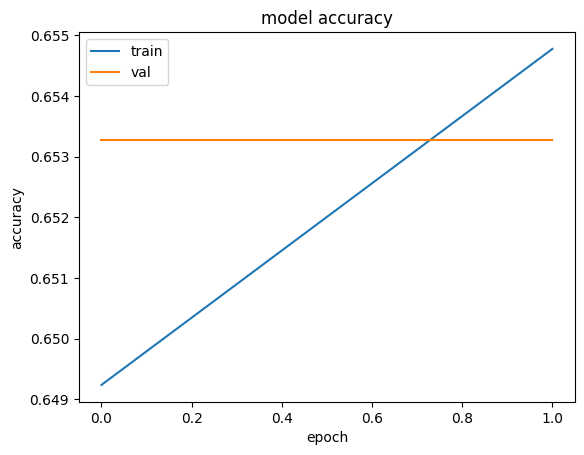

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

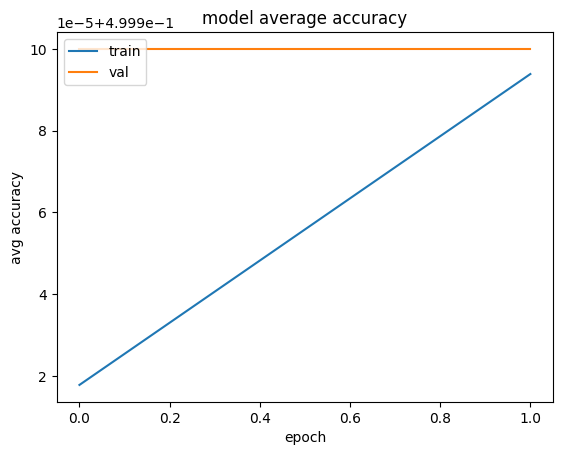

In [ ]:
plt.plot(history.history['average_accuracy'])
plt.plot(history.history['val_average_accuracy'])
plt.title('model average accuracy')
plt.ylabel('avg accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

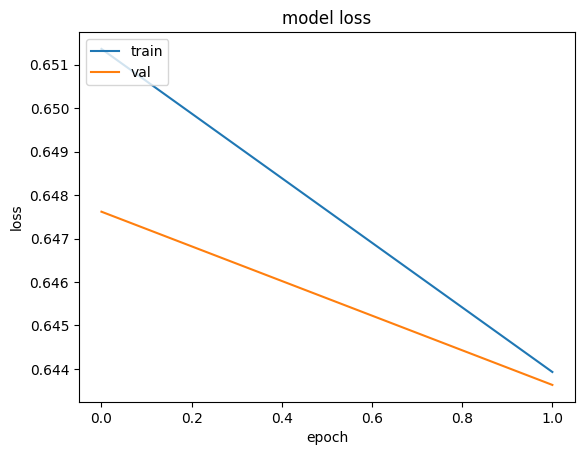

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


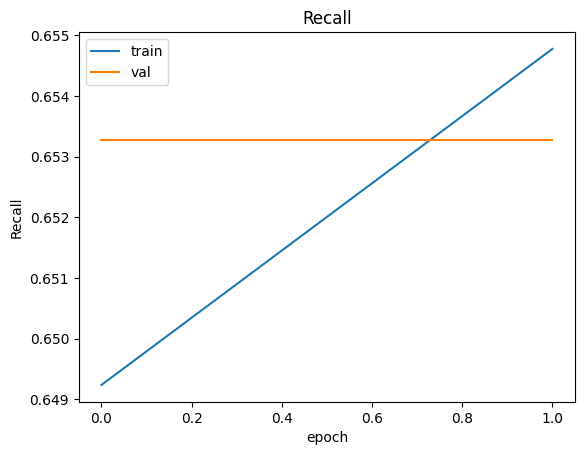

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss = k.evaluate(X_test,y_test)

2023-09-24 10:20:46.406640: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


1/9 [==>...........................] - ETA: 47s - loss: 0.6299 - accuracy: 0.6822 - average_accuracy: 0.5000 - precision: 0.6822 - recall: 0.6822

2023-09-24 10:20:52.136368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


2/9 [=====>........................] - ETA: 40s - loss: 0.6276 - accuracy: 0.6835 - average_accuracy: 0.5000 - precision: 0.6835 - recall: 0.6835

2023-09-24 10:20:57.978081: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


3/9 [=========>....................] - ETA: 34s - loss: 0.6354 - accuracy: 0.6652 - average_accuracy: 0.5000 - precision: 0.6652 - recall: 0.6652

2023-09-24 10:21:03.771666: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


4/9 [============>.................] - ETA: 28s - loss: 0.6353 - accuracy: 0.6659 - average_accuracy: 0.5000 - precision: 0.6659 - recall: 0.6659

2023-09-24 10:21:09.601448: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


9/9 [==============================] - 50s 6s/step - loss: 0.6392 - accuracy: 0.6596 - average_accuracy: 0.5000 - precision: 0.6596 - recall: 0.6596


In [ ]:
loss

[0.6391797065734863,
 0.6595688462257385,
 0.5,
 0.6595688462257385,
 0.6595688462257385]

In [ ]:
np.save('my_history.npy',history.history)

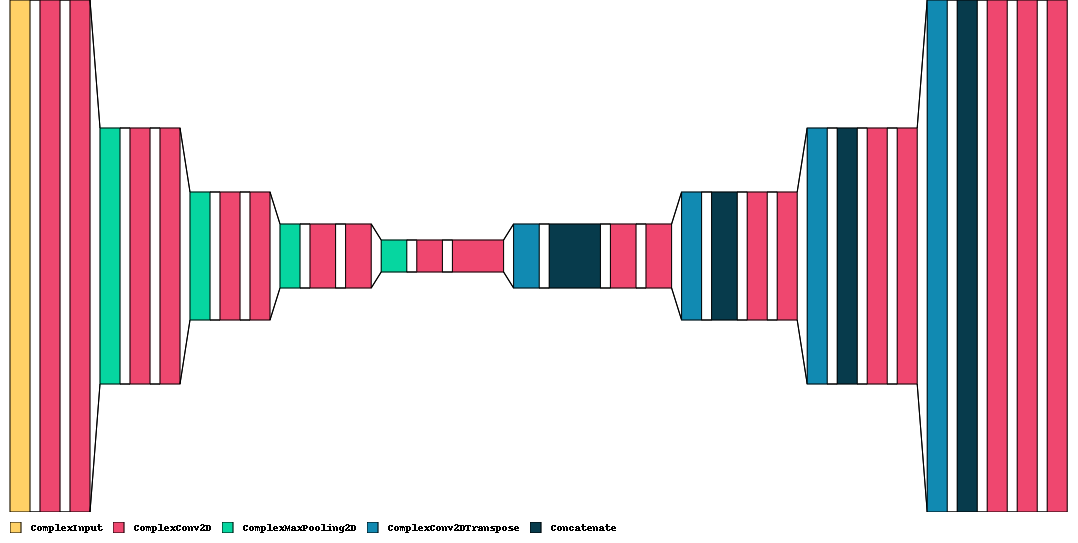

In [101]:
import visualkeras as vk

vk.layered_view(k, legend=True, draw_volume=False, to_file='U-net_no_drop.png')

In [ ]:
help(vk.layered_view)

Help on function layered_view in module visualkeras.layered:

layered_view(model, to_file: str = None, min_z: int = 20, min_xy: int = 20, max_z: int = 400, max_xy: int = 2000, scale_z: float = 0.1, scale_xy: float = 4, type_ignore: list = None, index_ignore: list = None, color_map: dict = None, one_dim_orientation: str = 'z', background_fill: Any = 'white', draw_volume: bool = True, padding: int = 10, spacing: int = 10, draw_funnel: bool = True, shade_step=10, legend: bool = False, font: <module 'PIL.ImageFont' from '/home/saumya/miniconda3/envs/tf/lib/python3.9/site-packages/PIL/ImageFont.py'> = None, font_color: Any = 'black') -> <module 'PIL.Image' from '/home/saumya/miniconda3/envs/tf/lib/python3.9/site-packages/PIL/Image.py'>
    Generates a architecture visualization for a given linear keras model (i.e. one input and output tensor for each
    layer) in layered style (great for CNN).
    
    :param model: A keras model that will be visualized.
    :param to_file: Path to the fil

In [ ]:
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
vk.layered_view(k, legend=True, font=font) # selected font

OSError: cannot open resource